# Imports, function definitions and data loading

In [0]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB, BernoulliNB

from sklearn.preprocessing import PolynomialFeatures
from sklearn.manifold import TSNE

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
%matplotlib inline


In [2]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 134448 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.18-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.18-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.18-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [6]:
df = pd.read_csv("drive/Опрос/Code/data_3.csv", sep=";")
df = df.drop(["Unnamed: 0", "Unnamed: 0.1"], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263 entries, 0 to 262
Columns: 115 entries, Отметка времени to encoded_1
dtypes: float64(1), int64(3), object(111)
memory usage: 236.4+ KB


In [0]:
# encode answers to numbers
df.replace({"Почти никогда":0, "Редко": 1, "Иногда": 2, "Обычно": 3, "Почти всегда":4}, inplace=True)
df.replace({"Не согласен":1, "Скорее несогласен": 2, "Трудно решить": 3, "Скорее согласен": 4, "Согласен":5}, inplace=True)
df.replace({"Да": 1, "Нет": 0}, inplace=True)
#df = df.rename(index=str, columns={"Unnamed: 4": "target"})
lables_dict = {
    '1' : u'природа',
    '2' : u'техника',
    '3' : u'знаковая система',
    '4' : u'худ. образ',
    '5' : u'человек',
    '6' : u'неизвестно'
}

In [0]:
def eq_compute(df):
    # create dataframe with eq computed result
    # it looks ugly, but it is nessesary because it is computed by rules
    # input: sliced dataframe with answers on EQ test
    # output: Data frame with empathy 	motivation 	relationship_management 	self_awareness 	self_management
    # pay attention that in the survey the questions "Мне комфортно говорить с любым человеком" was missed, so
    # in ls[4] zero is placed
    df_ = pd.DataFrame(data={"self_awareness":[], "self_management":[],"motivation":[],"empathy":[],"relationship_management":[],})
    # this list contains values of abilities for appending to DataFrame on each iteration
    ls = [0,0,0,0,0]
    for i in range(df.shape[0]):
        ls[0] = df.iloc[i,0] + (4 - df.iloc[i,1]) + df.iloc[i,2] + df.iloc[i,3] + df.iloc[i,4]
        ls[1] = df.iloc[i,5] + (4 - df.iloc[i,6]) + (4 - df.iloc[i,7]) + (4 - df.iloc[i,8]) + (4 - df.iloc[i,9])
        ls[2] = df.iloc[i,10] + df.iloc[i,11] + (4 - df.iloc[i,12]) + df.iloc[i,13] + df.iloc[i,14]
        ls[3] = (4 - df.iloc[i,15]) + df.iloc[i,16] + df.iloc[i,17] + (4 - df.iloc[i,18]) + df.iloc[i,19]
        ls[4] = (4 - df.iloc[i,20]) + 0 + df.iloc[i,21] + (4 - df.iloc[i,22]) + (4 - df.iloc[i,23])
        df_ = df_.append(pd.DataFrame({"self_awareness":ls[0], "self_management":ls[1],"motivation":ls[2],"empathy":ls[3],"relationship_management":ls[4],}, index=[i]))
    return df_

def bf_compute(df):
    # create dataframe with big five computed results
    # input: sliced dataframe with answers on BF test
    # output: DataFrame with Ex, Agr, Cons, Neur, Open.
    df_ = pd.DataFrame(data={"Ext":[], "Agr":[],"Cons":[],"Neuro":[],"Openn":[],})
    ls = [0,0,0,0,0]
    for i in range(df.shape[0]):
        ls[0] = 20 + df.iloc[i,0] - df.iloc[i,5] + df.iloc[i,10] - df.iloc[i,15] + df.iloc[i,20] - df.iloc[i,25] + df.iloc[i,30] - df.iloc[i,35] + df.iloc[i,40] - df.iloc[i,45]
        ls[1] = 14 - df.iloc[i,1] + df.iloc[i,6] - df.iloc[i,11] + df.iloc[i,16] - df.iloc[i,21] + df.iloc[i,26] - df.iloc[i,31] + df.iloc[i,36] + df.iloc[i,41] + df.iloc[i,46]
        ls[2] = 14 + df.iloc[i,2] - df.iloc[i,7] + df.iloc[i,12] - df.iloc[i,17] + df.iloc[i,22] - df.iloc[i,27] + df.iloc[i,32] - df.iloc[i,37] + df.iloc[i,42] + df.iloc[i,47] 
        ls[3] = 38 - df.iloc[i,3] + df.iloc[i,8] - df.iloc[i,13] + df.iloc[i,18] - df.iloc[i,23] - df.iloc[i,28] - df.iloc[i,33] - df.iloc[i,38] - df.iloc[i,43] - df.iloc[i,48] 
        ls[4] = 8 + df.iloc[i,4] - df.iloc[i,9] + df.iloc[i,14] - df.iloc[i,19] + df.iloc[i,24] - df.iloc[i,29] + df.iloc[i,34] + df.iloc[i,39] + df.iloc[i,44] + df.iloc[i,49] 
        df_ = df_.append(pd.DataFrame({"Ext":ls[0], "Agr":ls[1],"Cons":ls[2],"Neuro":ls[3],"Openn":ls[4],}, index=[i]))
    return df_

def prof_compute(df):
    # create dataframe with profession test computed results
    # input: sliced dataframe with answers on profession test
    # output: DataFrame with Nat, tech, sign, art, man
    df_ = pd.DataFrame(data={"Nat":[], "tech":[],"sign":[],"art":[],"man":[],})
    ls = [0,0,0,0,0]
    for i in range(df.shape[0]):
        ls[0] = df.iloc[i,3] + df.iloc[i,6] + df.iloc[i,10] + 2 * df.iloc[i,17] + 2 * df.iloc[i,24] + df.iloc[i,27]
        ls[1] = df.iloc[i,1] + 2 * df.iloc[i,8] + df.iloc[i,12] + 2 * df.iloc[i,15] + df.iloc[i,20] + df.iloc[i,25]
        ls[2] = df.iloc[i,4] + df.iloc[i,7] + 2 * df.iloc[i,13] + 2 * df.iloc[i,18] + df.iloc[i,21] + df.iloc[i,28]
        ls[3] = df.iloc[i,2] + 2 * df.iloc[i,9] + df.iloc[i,11] + 2 * df.iloc[i,16] + 2 * df.iloc[i,23] + df.iloc[i,29]
        ls[4] = df.iloc[i,0] + df.iloc[i,5] + 2 * df.iloc[i,14] + df.iloc[i,19] + 2 * df.iloc[i,22] + df.iloc[i,26]
        df_ = df_.append(pd.DataFrame({"Nat":ls[0], "tech":ls[1],"sign":ls[2],"art":ls[3],"man":ls[4],}, index=[i]))
    return df_

def get_polinomial_features(df, degree, target_name, var_list=None):
    # create dataframe, expanded by polinominal features 
    # df: dataframe
    # degree: polinominal degree
    # target_name: name of target column in dataframe
    # var_list: list of desired variables, to which will be apply an operation
    #            if None, it will use all columns excepted target 
    
    # first of all, we must reset indeces of dataframe, otherwise there will be very much Nan because of index mismatch
    df = df.reset_index(drop=True)
    # put target variavle in another variable
    poly_target = df[target_name]
    if var_list == None:
        # get a variable list, in which we want to apply PolynomialFeatures
        var_list = df.drop([target_name], axis=1).columns
    # create a blank dataset with desired columns. In this case, is all without target
    poly_features = df.drop([target_name], axis=1)
    # Create the polynomial object with specified degree
    poly_transformer = PolynomialFeatures(degree = degree)
    poly_features = poly_transformer.fit_transform(poly_features[var_list])
    # create datafrapme with new named columns, that will be got from poly_transformer
    poly_features = pd.DataFrame(poly_features, 
                                 columns = poly_transformer.get_feature_names(input_features=var_list))
    poly_features[target_name] = poly_target
    return poly_features

def kde_target(var_name, target_name, df):
    
    # Calculate the correlation coefficient between the variable and the target
    # var_name : column name of variable, which need to check
    # target_name: name of target column
    # df : dataframe
    corr = df[target_name].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.loc[df[df['target'] == 0].index, var_name].median()
    avg_not_repaid = df.loc[df[df['target'] == 1].index, var_name].median()
    
    plt.figure(figsize = (20, 20))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.loc[df[df['target'] == 0].index, var_name], label = target_name + ' == 0')
    sns.kdeplot(df.loc[df[df['target'] == 1].index, var_name], label = target_name + ' == 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the %s is %0.4f' % (var_name, target_name, corr))
    # Print out average values
    #print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    # print('Median value for loan that was repaid =     %0.4f' % avg_repaid)

    
def plot_kde(df, target_name, var_name=None):
    # it is just an interface for kde_plot
    # df : dataframe
    # target_name: name of target column
    # var_name: varibale names, that will be shown
    if var_name == None:
        for i in df.columns:
            if i == target_name:
                continue
            kde_target(i, target_name, df)
    elif isinstance(var_name, list):
        for i in var_name:
            if i == target_name:
                continue
            kde_target(i, target_name, df)
    else:
        kde_target(var_name, target_name, df)
    plt.show()
        
def correletion(df, target_corr):
    # return a correlation by column or columns if it list
    # df: dataframe
    # target_corr: column, that need to estimate
    correlations = df.corr()[target_corr].abs().sort_values()
    return correlations

def get_featrue_importance_lr(model, columns_list, x):
    # return feature importance from Logistic Regression model
    # model: sklearn model of logistic regression
    # colunms_list: list with names of columns, that paricipated in creating of model 
    # x : data
    ls = list()
    for i in zip((clf.coef_* np.std(x,0))[0], columns_list):
        ls.append(i)
    ls.sort(reverse=True)
    df = pd.DataFrame(ls, columns=["value", "name"])
    return df

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Reds,
                          fig_size=(5,5)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           #xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [0]:
# df.iloc[:,7:31] - EQ-test
# df.iloc[:, 31:81] - big five test
# df.iloc[:, 81:111] - prof test
df_with_tests = pd.concat([df, eq_compute(df.iloc[:,7:31]), bf_compute(df.iloc[:, 31:81]), prof_compute(df.iloc[:,81:111])], axis=1)
df_with_tests = df_with_tests.rename(index=str, columns={"Unnamed: 4": "target"})

# EDA

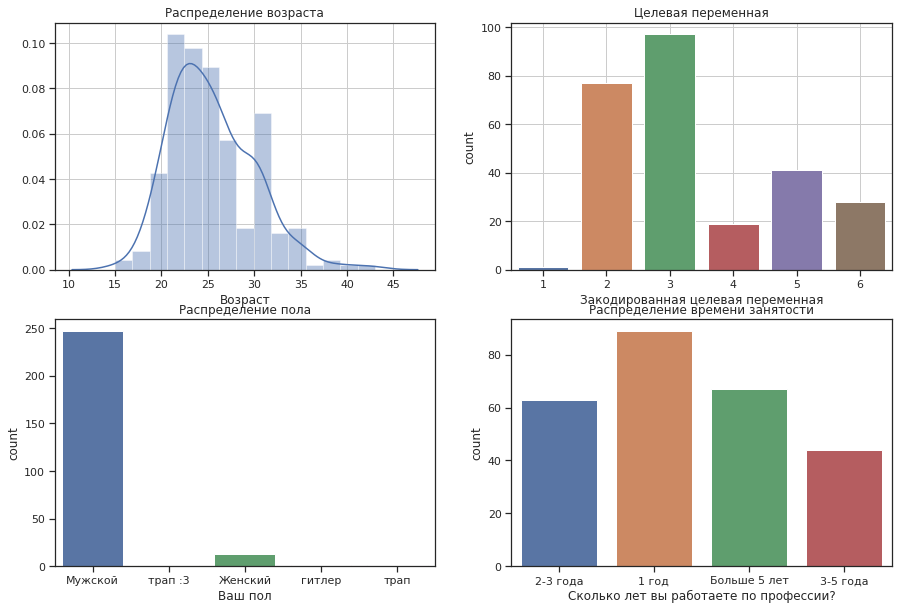

In [30]:
plt.figure(figsize=(15,10))
ax = plt.subplot(2,2,1)
sns.distplot(df.iloc[:,2], axlabel=u"Возраст", ax=ax)
ax.set_title(u"Распределение возраста")
ax.grid(True)
#plt.figure(figsize=(20,20))
ax1 = plt.subplot(2,2,2)
sns.countplot(df.iloc[:,4], ax=ax1)
ax1.set_xlabel(u"Закодированная целевая переменная")
ax1.set_title(u"Целевая переменная")
ax1.grid(True)
ax3 = plt.subplot(2,2,3)
sns.countplot(df.iloc[:,1], )
ax3.set_title(u"Распределение пола")
ax4 = plt.subplot(2,2,4)
sns.countplot(df.iloc[:,6], )
ax4.set_title(u"Распределение времени занятости")
plt.savefig("drive/Опрос/pics/1.png")
plt.show()

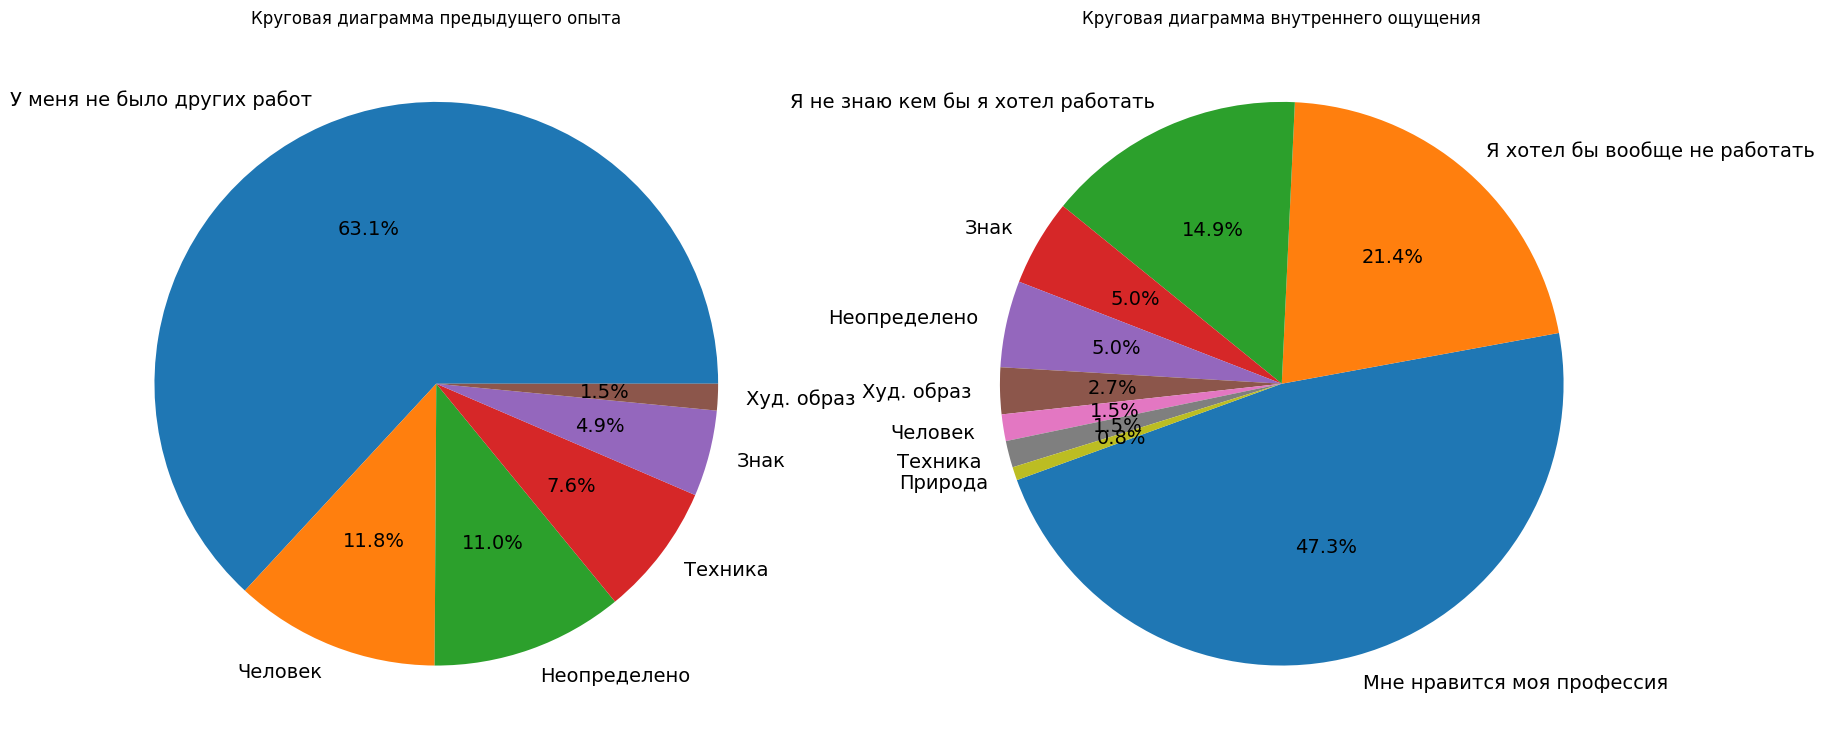

In [22]:
import pylab
plt.figure(figsize=(20,15), dpi=100)
ax = plt.subplot(1,2,1)
df.iloc[:,-1].replace({
    0:"У меня не было других работ",
    1:"Природа",
    2:"Техника",
    3:"Знак",
    4:"Худ. образ",
    5:"Человек",
    6:"Неопределено"}).value_counts().plot(kind='pie', 
                                        subplots=True, 
                                        figsize=(8, 8), 
                                        autopct='%1.1f%%', 
                                        fontsize=14,
                                        )
pylab.ylabel('')
pylab.title("Круговая диаграмма предыдущего опыта")
ax = plt.subplot(1,2,2)
df.iloc[:,-3].replace({
    0:"У меня не было других работ",
    1:"Природа",
    2:"Техника",
    3:"Знак",
    4:"Худ. образ",
    5:"Человек",
    6:"Неопределено",
    7:"Мне нравится моя профессия",
    8:"Я хотел бы вообще не работать",
    9:"Я не знаю кем бы я хотел работать"}).value_counts().plot(kind='pie',
                                                                subplots=True,
                                                                figsize=(8, 8),
                                                                autopct='%1.1f%%',
                                                                startangle=200,
                                                                fontsize=14,)
pylab.ylabel('')
pylab.title("Круговая диаграмма внутреннего ощущения")
plt.savefig("drive/Опрос/pics/2.png")

In [0]:
print("Количество респондентов, которым нравится текущее место и которые не ратали раньше: {}".format(len(df[(df.encoded == 7.0) & (df.encoded_1 == 0)])))
print("Количество респондентов, которым нравится текущее место, но которые ратали раньше: {}".format(len(df[(df.encoded == 7.0) & (df.encoded_1 != 0)])))

Количество респондентов, которым нравится текущее место и которые не ратали раньше: 83
Количество респондентов, которым нравится текущее место, но которые ратали раньше: 41


In [0]:
print("Количество респондентов, которым нравится текущее место и которые не ратали раньше в рамках 20-25: {}".format(len(df[(df.encoded == 7.0) & (df.encoded_1 == 0) & (df['Ваш возраст'] > 20)& (df['Ваш возраст'] <25)])))
print("Количество респондентов, которым нравится текущее место, но которые ратали раньше в рамках 20-25: {}".format(len(df[(df.encoded == 7.0) & (df.encoded_1 != 0)& (df['Ваш возраст'] > 20)& (df['Ваш возраст'] <25)])))

Количество респондентов, которым нравится текущее место и которые не ратали раньше в рамках 20-25: 32
Количество респондентов, которым нравится текущее место, но которые ратали раньше в рамках 20-25: 11


In [0]:
print("Количество респондентов, которым нравится текущее место и которые не ратали раньше, больше 25: {}".format(len(df[(df.encoded == 7.0) & (df.encoded_1 == 0)  & (df['Ваш возраст'] > 25)])))
print("Количество респондентов, которым нравится текущее место, но которые ратали раньше, больше 25: {}".format(len(df[(df.encoded == 7.0) & (df.encoded_1 != 0) & (df['Ваш возраст'] > 25)])))

Количество респондентов, которым нравится текущее место и которые не ратали раньше, больше 25: 32
Количество респондентов, которым нравится текущее место, но которые ратали раньше, больше 25: 23


In [0]:
print("Количество респондентов, которым не хотят работать, больше 25: {}".format(len(df[(df.encoded == 8.0) & (df['Ваш возраст'] > 25)])))
print("Количество респондентов, которым не хотят работать, меньше 25: {}".format(len(df[(df.encoded == 8.0) & (df['Ваш возраст'] < 25)])))

Количество респондентов, которым не хотят работать, больше 25: 32
Количество респондентов, которым не хотят работать, меньше 25: 22


<Figure size 1200x560 with 0 Axes>

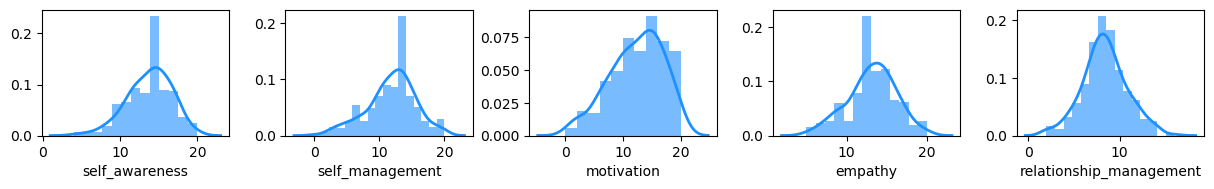

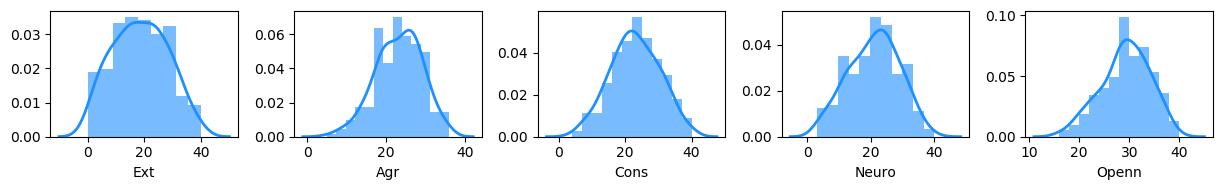

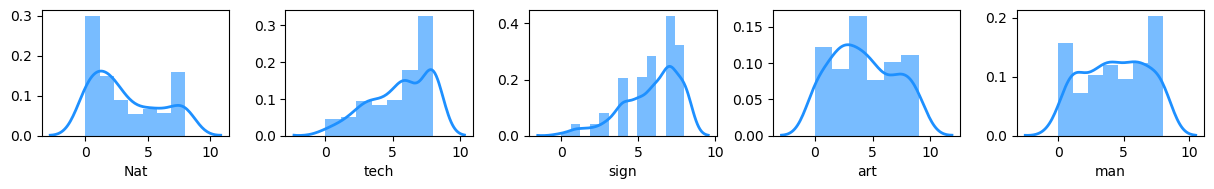

In [0]:
# draws sepated distribtutions of each factor grouped by tests
import seaborn as sns

columns = 5
rows = 1
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})
plt.figure(figsize=(15,7), dpi= 80)

tests_columns = list(df_with_tests.keys()[-15:])
#fig.subplots_adjust(hspace=0.6, wspace=1.5)
for i in range(1,4):
    plt.figure(figsize=(15,7), dpi= 100)
    for j in range(1, 6):
        plt.subplot(3, 5, j)
        plt.subplots_adjust(hspace=0.6, wspace=0.3)
        sns.distplot(df_with_tests[tests_columns[(j-1) + 5 * (i-1)]], color="dodgerblue", kde=True, **kwargs)
    plt.show()


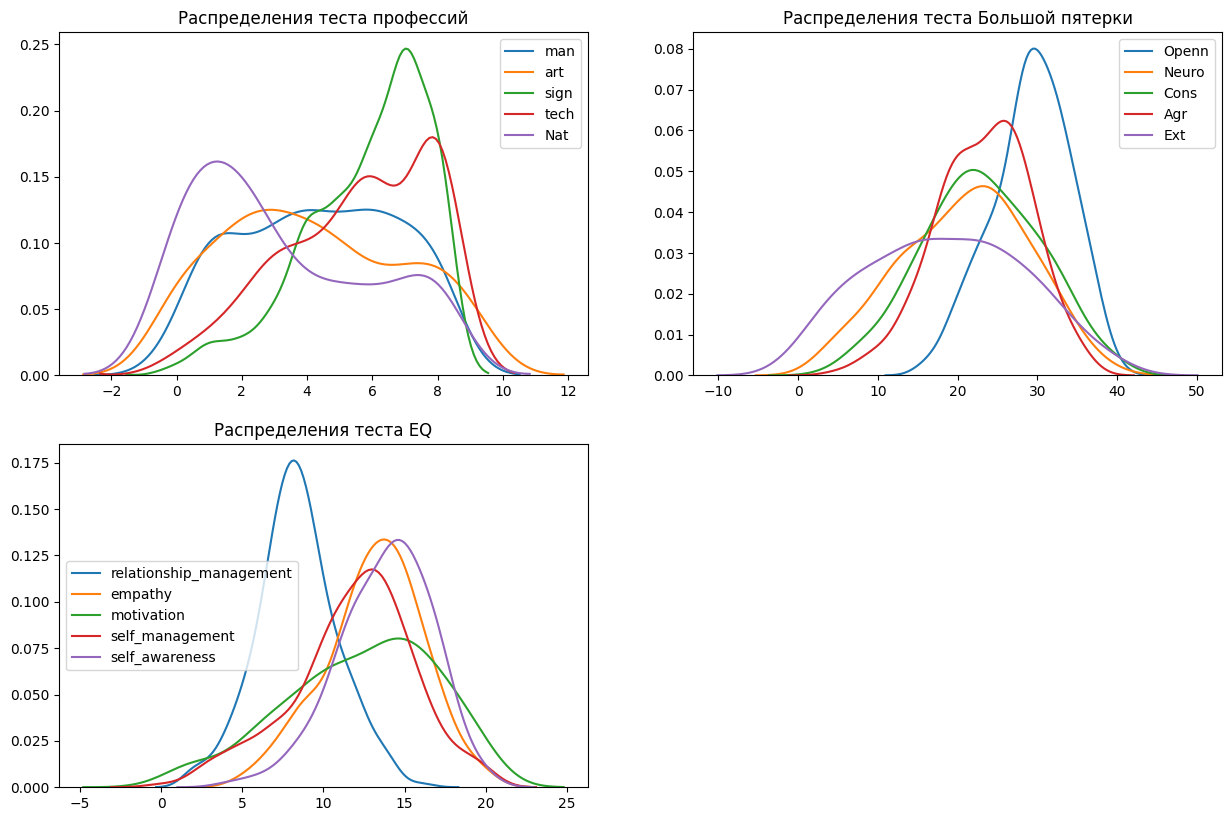

In [23]:
# draws all factor distributions of each test on one picture
import pylab
plt.figure(figsize=(15,10), dpi= 100)
names = [u"Распределения теста профессий", u"Распределения теста Большой пятерки", u"Распределения теста EQ"]
for _ in range(3):
    plt.subplot(2,2,_+1)
    for i in range(1,6):
        sns.kdeplot(df_with_tests.iloc[:,-i - 5*_])
    pylab.title(names[_])
    plt.savefig("drive/Опрос/pics/3.png")
plt.show()


In [25]:
# Take a data for sign and tech professions
# Shuffle
df_with_tests = df_with_tests.sample(frac=1).reset_index(drop=True)
# These three complex expressions performs filtering data by man-technologies and man-sign_systems categories with 
# condition, that profession is liked by responders.
x_tests = df_with_tests[((df_with_tests["target"] == 2) | (df_with_tests["target"] == 3)) & df_with_tests["Вам нравится ваша профессия? Не по зарплате, не по удобствам и т. д., а именно сама деятельность."] == 1].iloc[:,-15:]
x_quests = df_with_tests[((df_with_tests["target"] == 2) | (df_with_tests["target"] == 3)) & df_with_tests["Вам нравится ваша профессия? Не по зарплате, не по удобствам и т. д., а именно сама деятельность."] == 1].iloc[:,7:-19]
target = df_with_tests[((df_with_tests["target"] == 2) | (df_with_tests["target"] == 3)) & df_with_tests["Вам нравится ваша профессия? Не по зарплате, не по удобствам и т. д., а именно сама деятельность."] == 1]["target"]
# bring some order in the dataset
target.replace({2: 0, 3: 1}, inplace=True)
# now data contains only tests results, target and questions
data = pd.concat([x_tests,x_quests, target], axis="columns")

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [0]:
# draws the box plots
plt.figure(figsize=(10,10), dpi= 100)
for i in range(1,4):
    plt.subplot(3, 1, i)
    plt.subplots_adjust(hspace=0.6, wspace=0.3)
    sns.boxplot(data.iloc[:,5 * (i-1) :5* (i)], data=data)
plt.show() 

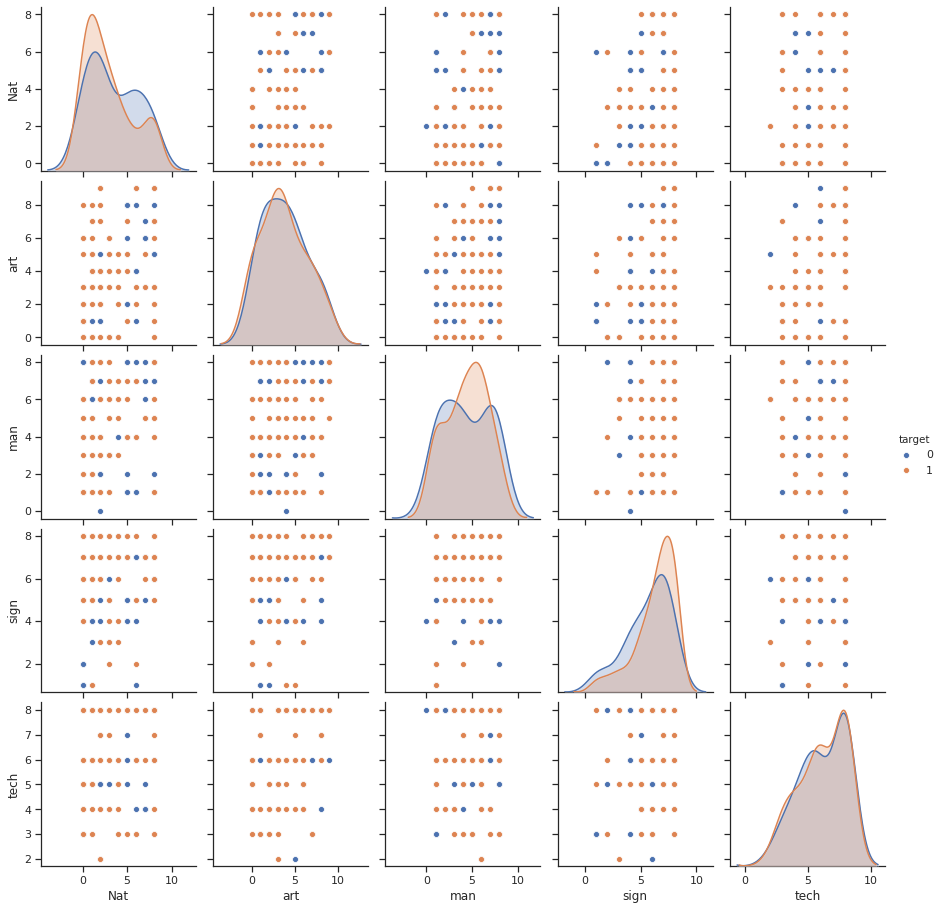

In [26]:
# Next three celss draws pairplot for each test against target
#df_with_tests[['Nat', 'art', "man", "sign", "tech"]].hist(histtype="barstacked")
sns.set(style="ticks")
sns.pairplot(data[['Nat', 'art', "man", "sign", "tech", 'target']], hue="target")
plt.savefig("drive/Опрос/pics/4.png")

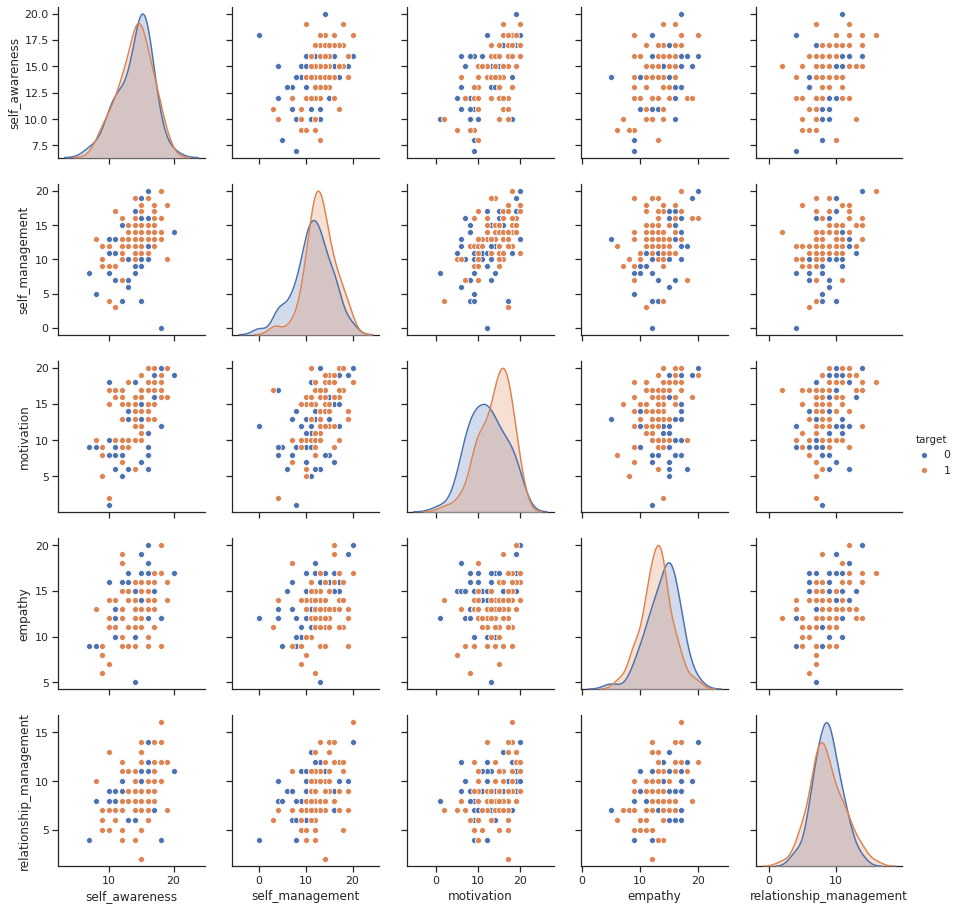

In [27]:
# df_with_tests[["self_awareness", "self_management","motivation","empathy","relationship_management"]].hist(histtype="barstacked")

sns.set(style="ticks")
sns.pairplot(data[["self_awareness", "self_management","motivation","empathy","relationship_management", "target"]], hue="target")
plt.savefig("drive/Опрос/pics/eq.png")

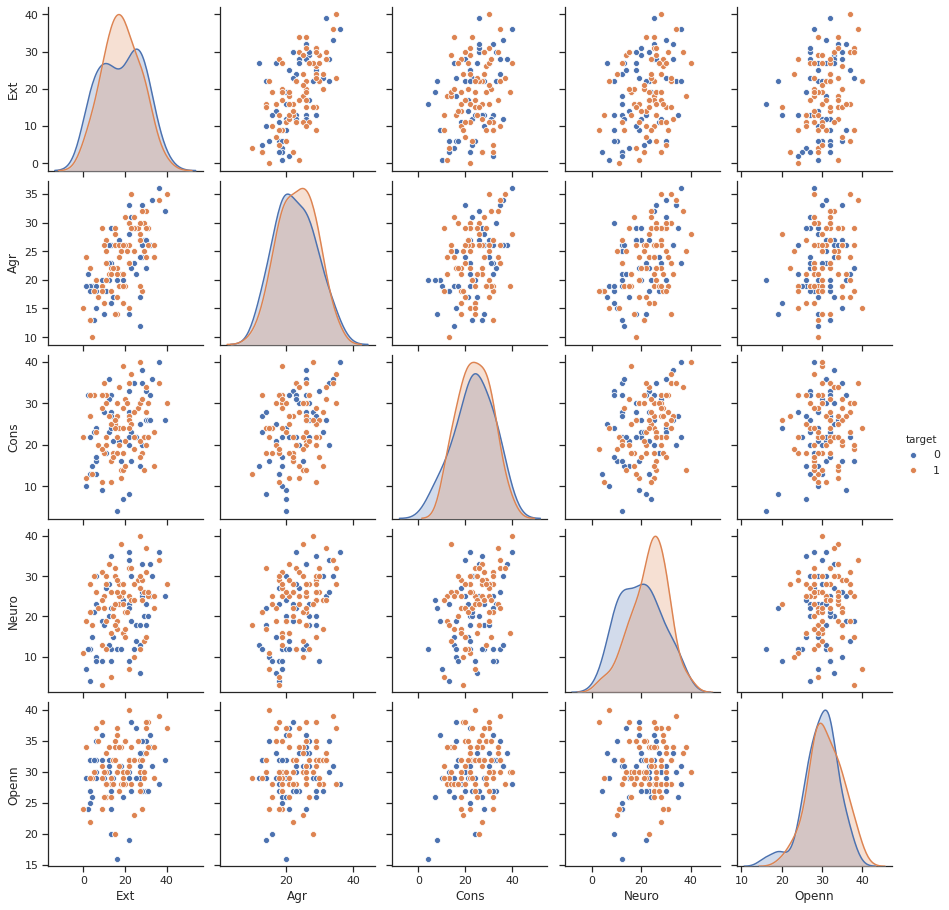

In [28]:
# df_with_tests["target"].hist()
sns.set(style="ticks")
sns.pairplot(data[["Ext", "Agr","Cons","Neuro","Openn", 'target']], hue="target")
plt.savefig("drive/Опрос/pics/bf.png")

In [0]:
#encoding russian questions to form Q#
russian = data.columns[15:-1]
repl = ['Q' + str(x) for x in range(len(russian))]
repl = {x:y for x,y in zip(russian, repl)}
repl_revers = {y:x for x,y in repl.items()}
data = data.rename(index=str, columns=repl)

In [0]:
# plot kernel density estimation
plot_kde(data, 'target', var_name=list(data.columns[:15]))

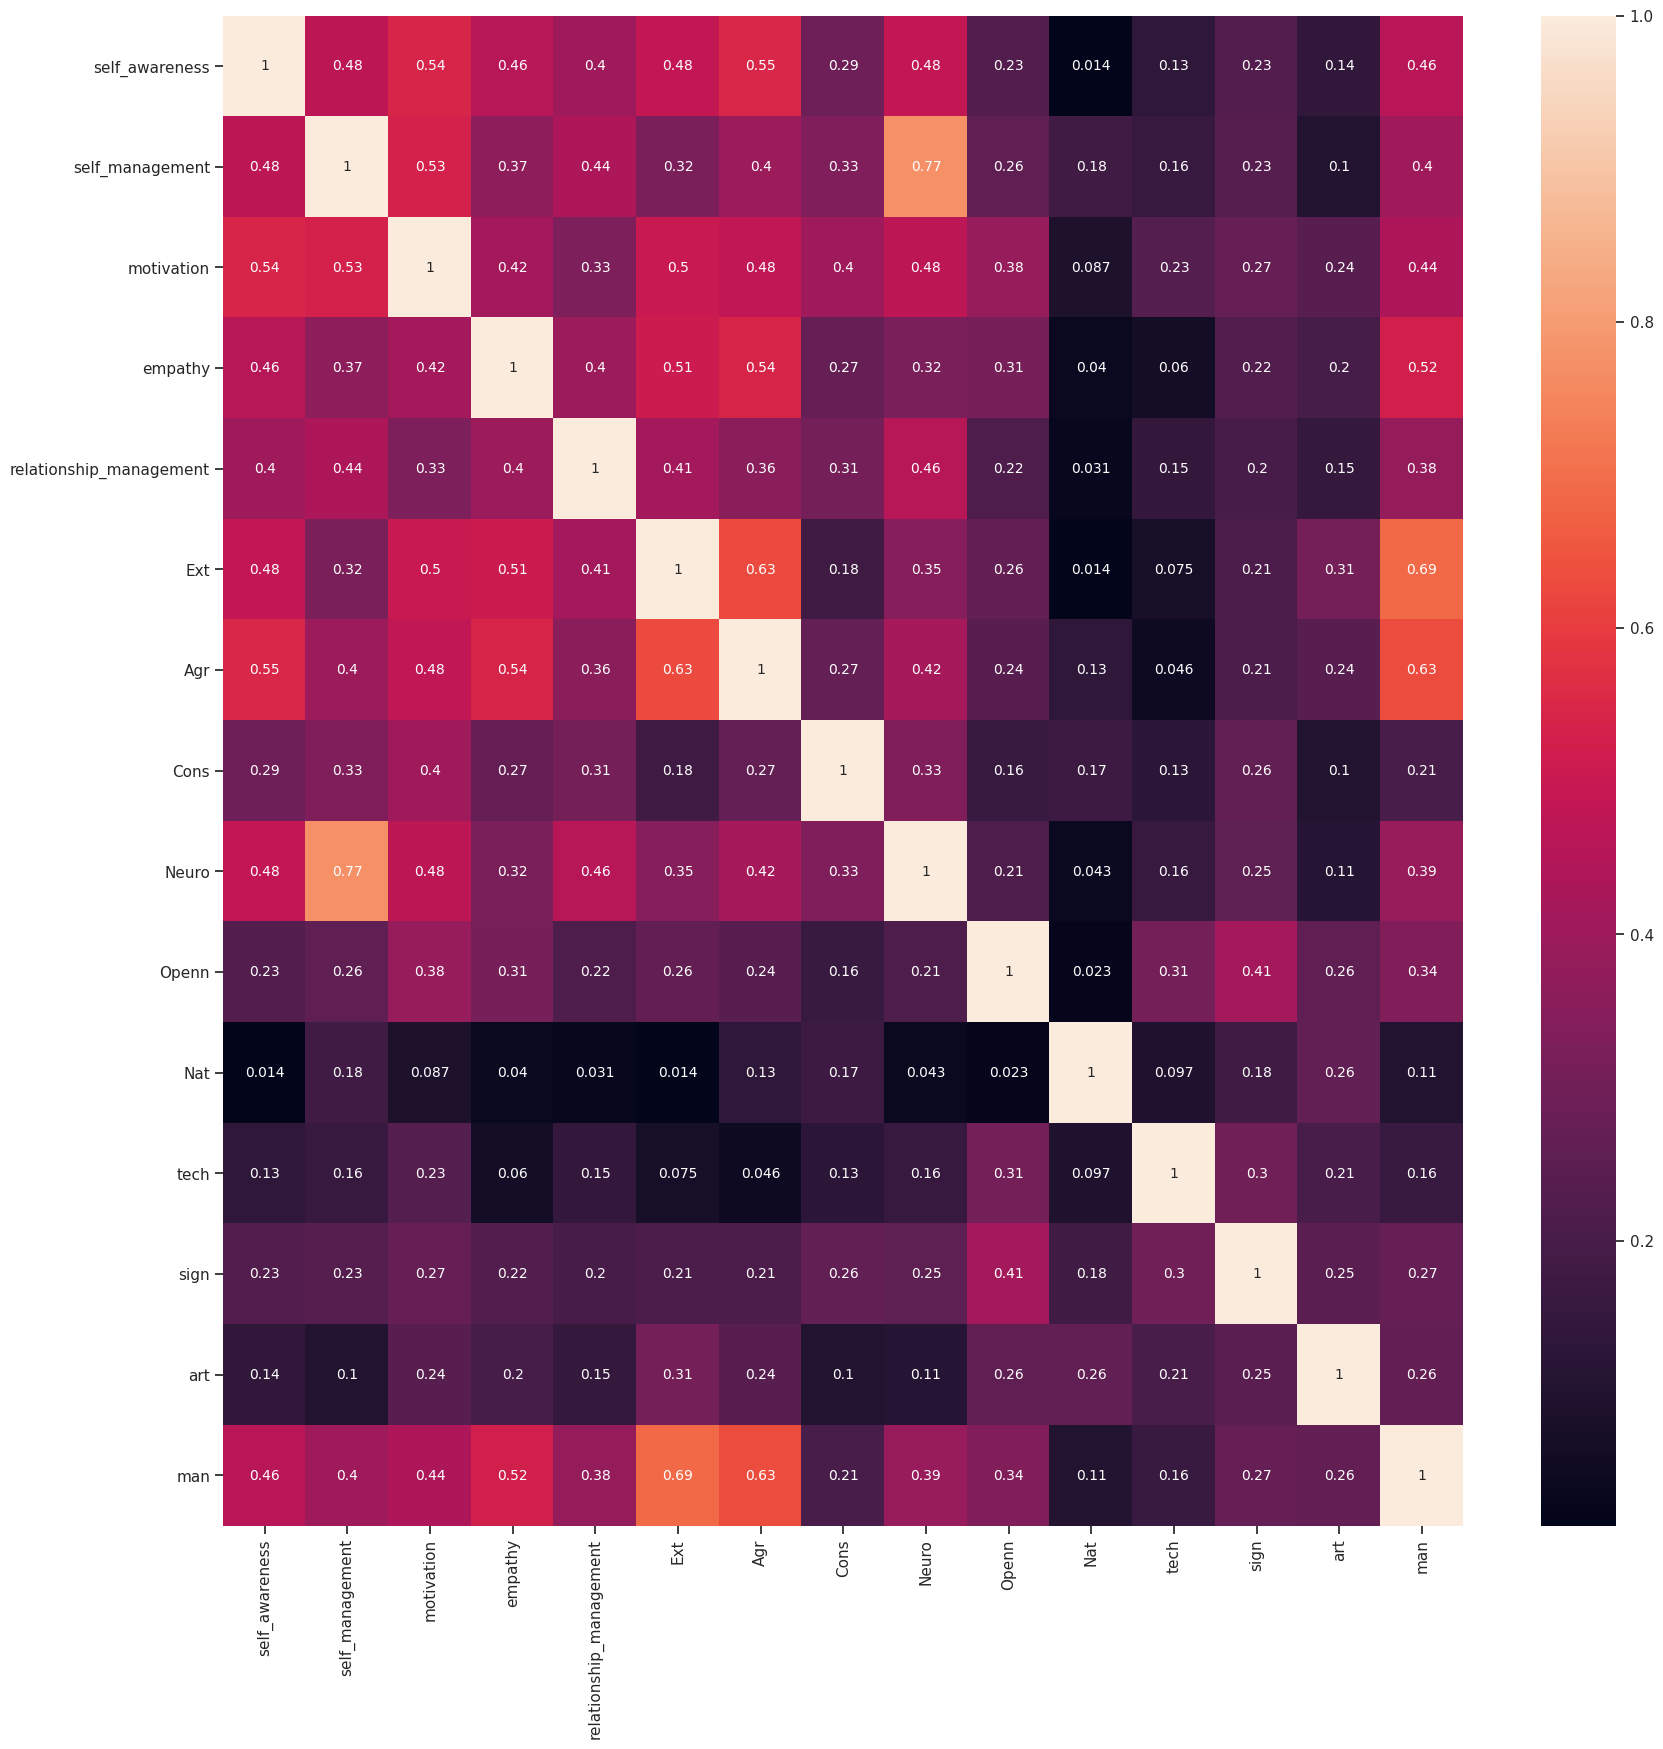

In [36]:
# draw a heatmap of test results
# sometimes it is showed with incorrect font size. Try to repeat.
plt.figure(figsize=(20,20), dpi =100)
ax = sns.heatmap(df_with_tests.iloc[:,-15:].corr(), annot=True, annot_kws={"size": 10})
plt.savefig("drive/Опрос/pics/hm_for_all_tests.png")

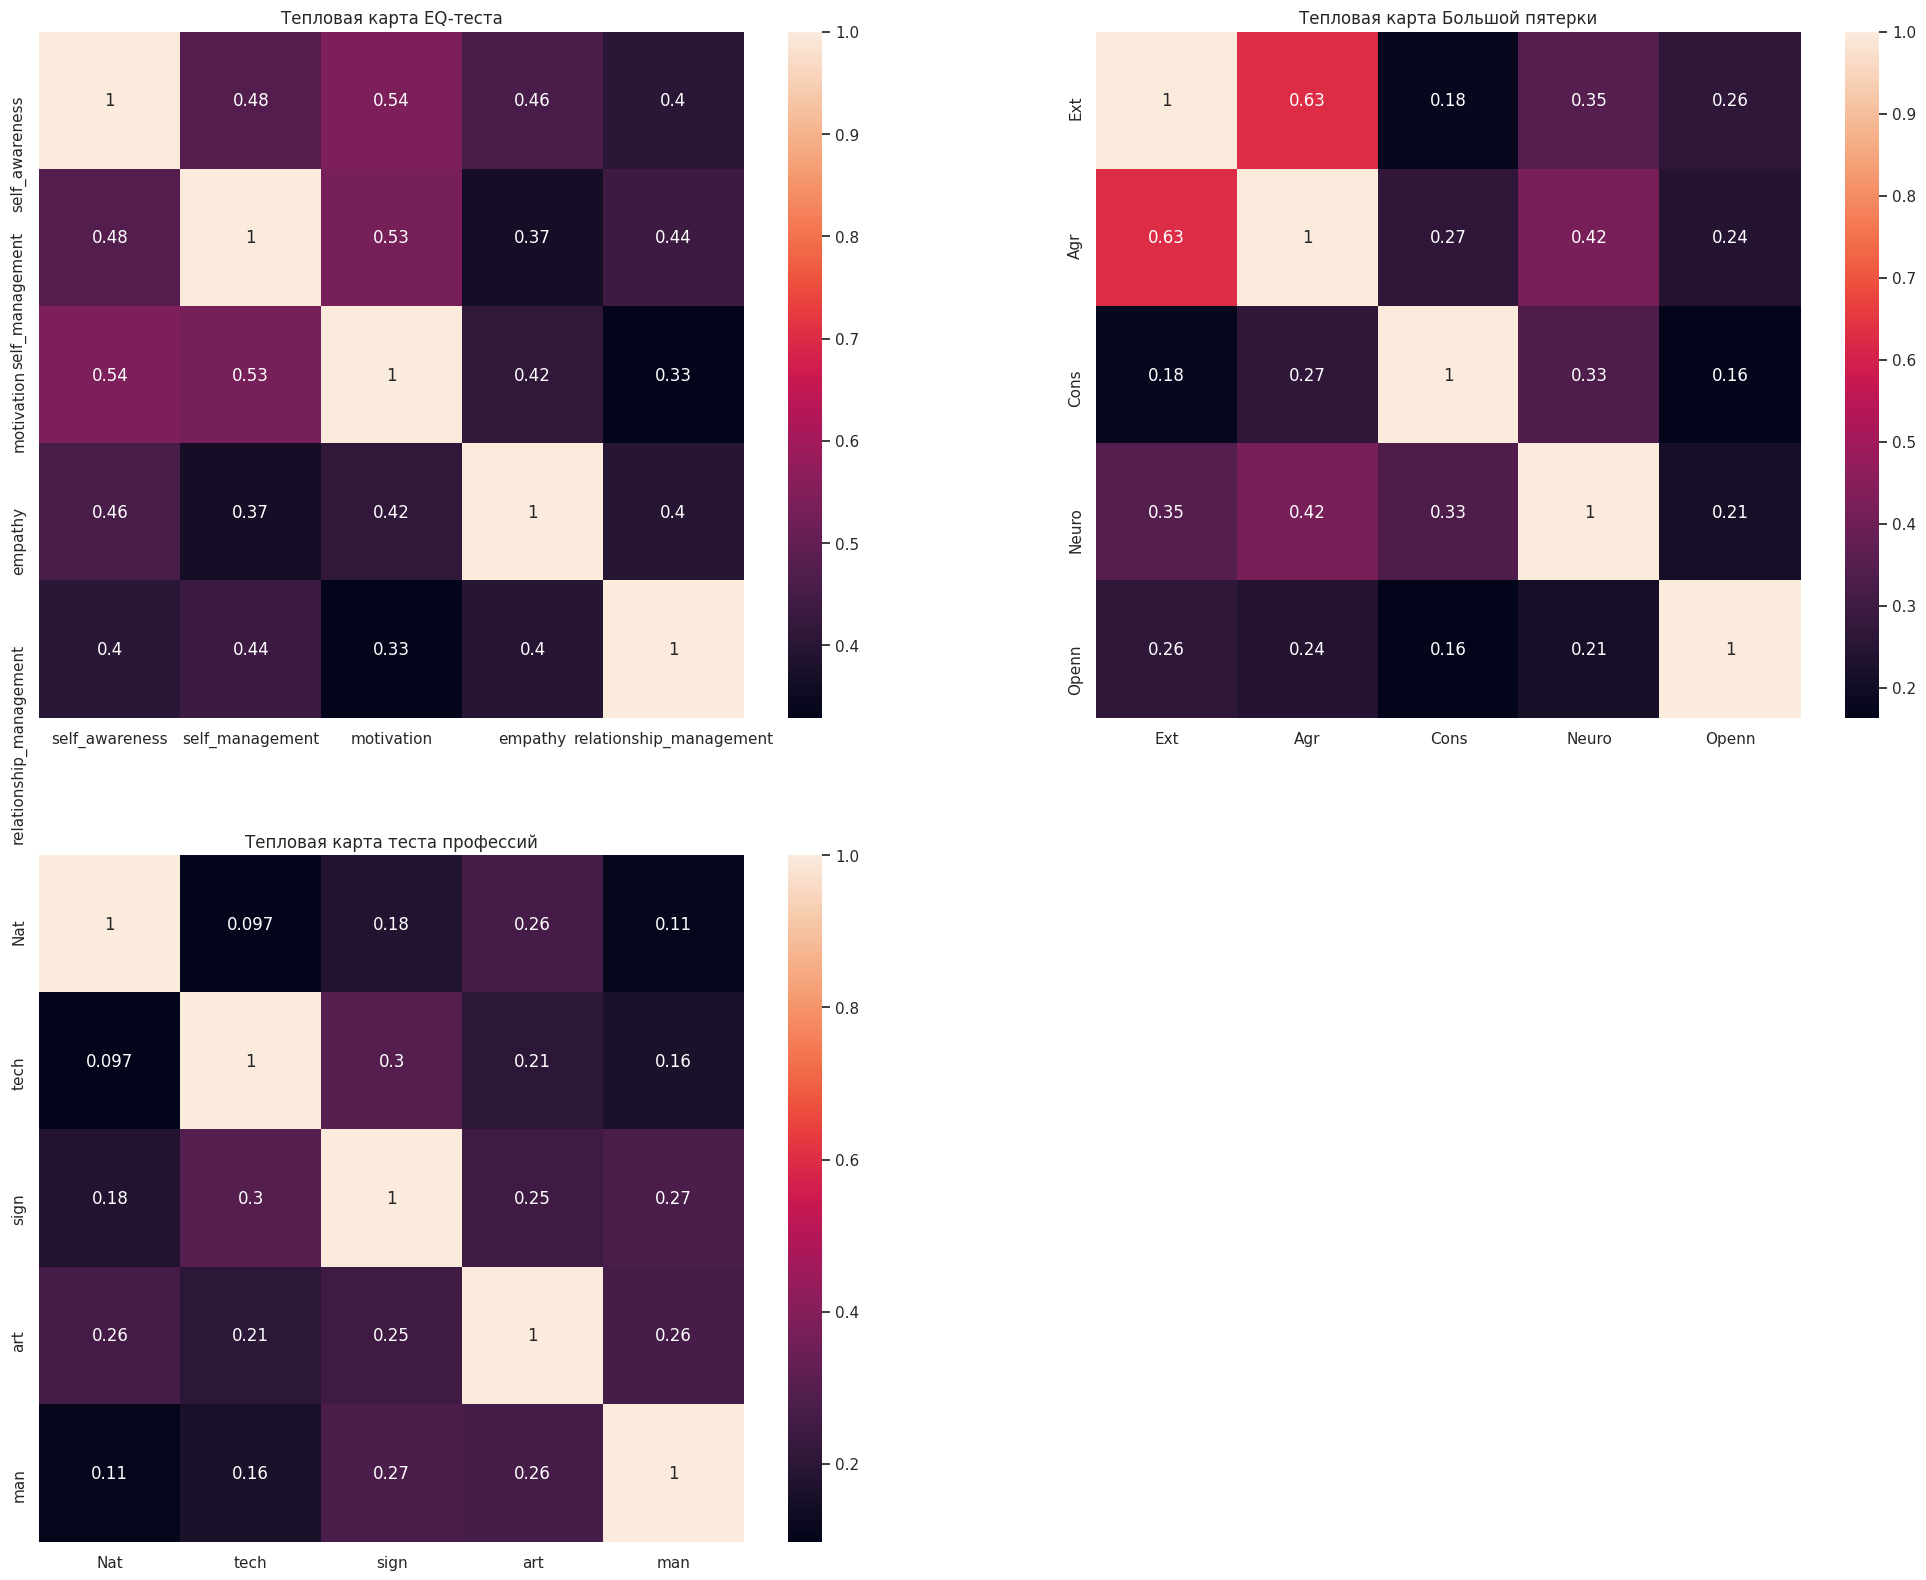

In [38]:
# draws the heatmap of each test
plt.figure(figsize=(25,20), dpi=100)
ax = plt.subplot(2,2,1)
sns.set(font_scale=1)
ax = sns.heatmap(df_with_tests.iloc[:,-15:-10].corr(), annot=True)
pylab.title(u"Тепловая карта EQ-теста")

ax = plt.subplot(2,2,2)
sns.set(font_scale=1)
ax = sns.heatmap(df_with_tests.iloc[:,-10:-5].corr(), annot=True)
pylab.title(u"Тепловая карта Большой пятерки")

ax = plt.subplot(2,2,3)
sns.set(font_scale=1)
ax = sns.heatmap(df_with_tests.iloc[:,-5:].corr(), annot=True)
pylab.title(u"Тепловая карта теста профессий")
plt.savefig("drive/Опрос/pics/hm_for_all_tests_sep.png")

# Preparing and little analysis of profession test

In [0]:
# this functions computes the results of profficiency tests in differ manners
# hard_res_only manner allows only one answer, error otherwise
# soft_res_only manner allows only several answers, error if there is only one
# joint res is a union of previous two
# for now, the hard res only will be used
import numpy as np

def hard_res_only(raw):
    m = np.max(raw)
    res = []
    for i,v in enumerate(raw):
        if v == m:
            res.append(i)
    if len(res) > 1:
        return -1
    else:
        return res[0]

def joint_res(raw):
    m = np.max(raw)
    res = []
    for i,v in enumerate(raw):
        if v == m:
            res.append(i)
    return res

def soft_res_only(raw):
    m = np.max(raw)
    res = []
    for i,v in enumerate(raw):
        if v == m:
            res.append(i)
    if len(res) < 2:
        return [-1]
    else:
        return res

In [0]:
d = {"hard_res_only" : [],  "soft_res_only": [], "joint_res": []}
for idx, raw in df_with_tests.iloc[:, -5:].iterrows():
    profs = list(df_with_tests.iloc[:, -5:].columns)
    profs.append("e")
    d['hard_res_only'].append(profs[hard_res_only(raw)])

for idx, raw in df_with_tests.iloc[:, -5:].iterrows():
    profs = list(df_with_tests.iloc[:, -5:].columns)
    d['joint_res'].append("|".join([profs[x] for x in joint_res(raw)]))

for idx, raw in df_with_tests.iloc[:, -5:].iterrows():
    profs = list(df_with_tests.iloc[:, -5:].columns)
    profs.append("e")
    d['soft_res_only'].append("|".join([profs[x] for x in soft_res_only(raw)]))

In [0]:
idx2prof = {1:"Nat", 2: "tech", 3:"sign", 4:"art", 5:"man", 6:"unk"}

In [0]:
# this df contain test results and special columns for prof test 
df_tests_prof = pd.concat([df_with_tests.reset_index(drop=True), pd.DataFrame(d).reset_index(drop=True)], axis="columns",)

In [0]:
# the str postfix defins labels of professions
df_tests_prof["target_str"] = df_tests_prof.target.replace(idx2prof)

Совпадение результата теста, текущей профессии, нравится ли профессия. - гипотеза о корректности теста.

In [44]:
# the amount of mans who likes their jobs and it matches with the prof-test result
len(df_tests_prof[(df_tests_prof.target_str == df_tests_prof.hard_res_only) & (df_tests_prof.iloc[:, 5] == 1)])

44

In [45]:
len(df_tests_prof[(df_tests_prof.iloc[:, 5] == 1)])

195

Проверить, как результаты теста по профессии согласуются со столбцом о внутреннем ощущении.

In [0]:
# the data frame of who expact that another profession would be good for them
sliced_expectations = df_tests_prof[df_tests_prof.encoded.isin([1,2,3,4,5])]
sliced_expectations.fillna(6)

In [47]:
sliced_expectations["encoded_str"] = df_tests_prof.encoded.replace(idx2prof)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [48]:
# the amount of match expectations of mans with hard test result
len(sliced_expectations[(sliced_expectations.encoded_str == sliced_expectations.hard_res_only)])

8

In [49]:
# general amount of expectation peopale without unrecognized wants
len(sliced_expectations[(sliced_expectations.encoded_str != "unk")])

30

# Classifier building


## Classifyer with test results only

In [0]:
test_only = data.iloc[:,:15]
test_only["target"] = data['target']

In [0]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

std_sc = StandardScaler()
x = std_sc.fit_transform(test_only.drop(columns=["target"]))

x_tr, x_ts, y_tr, y_ts = train_test_split(x, test_only["target"], test_size=0.30)

0.5952380952380952 0.05143444998736394
Normalized confusion matrix
[[0.46153846 0.53846154]
 [0.16       0.84      ]]


<Figure size 600x400 with 0 Axes>

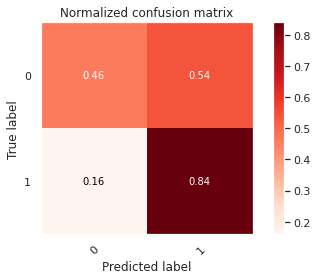

In [61]:
# This is Logistic Regression classifier
clf = LogisticRegression(penalty="l2", C=75, random_state=123)
cvs = cross_val_score(clf, x, data["target"], scoring='accuracy', cv=3)
print(np.mean(cvs), np.std(cvs))
clf.fit(x_tr, y_tr)
plt.figure( dpi=100)
plot_confusion_matrix(np.array(y_ts), clf.predict(x_ts), [0,1], normalize=True, )
plt.grid(False)
plt.savefig("drive/Опрос/pics/cm_lr_test_only.png")

0.5952380952380952 0.0847387162859628
Normalized confusion matrix
[[0.53846154 0.46153846]
 [0.32       0.68      ]]


<Figure size 600x400 with 0 Axes>

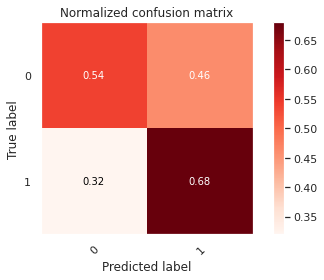

In [65]:
# This is RandomForest Classifier classifier
clf = RandomForestClassifier(n_estimators=100, oob_score=True, criterion='entropy', random_state=123)
cvs = cross_val_score(clf, x, data["target"], scoring='accuracy', cv=3)
print(np.mean(cvs), np.std(cvs))
clf.fit(x_tr, y_tr)
plt.figure( dpi=100)
plot_confusion_matrix(np.array(y_ts), clf.predict(x_ts), [0,1], normalize=True)
plt.grid(False)
plt.savefig("drive/Опрос/pics/cm_rf_test_only.png")

## Classifyer with test only, with polynom

In [0]:
test_only_pol = get_polinomial_features(test_only, 2, 'target')

In [0]:
correlations = correletion(test_only_pol, 'target')
correlations = correlations.drop('1')

In [0]:
list_filterd_columns = correlations[(correlations > 0.1)].keys()
list_filterd_columns = list_filterd_columns.drop('target')

In [0]:
std_sc = StandardScaler()
x = std_sc.fit_transform(test_only_pol.drop(columns=["target"])[list_filterd_columns])

x_tr, x_ts, y_tr, y_ts = train_test_split(x, test_only_pol["target"], test_size=0.30)

0.6349206349206349 0.04046840883803797
Normalized confusion matrix
[[0.5  0.5 ]
 [0.15 0.85]]


<Figure size 600x400 with 0 Axes>

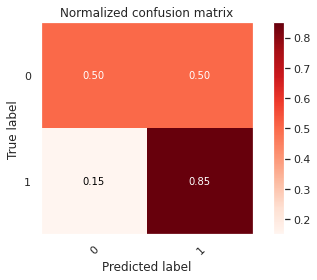

In [71]:
# This is Logistic Regression classifier
clf = LogisticRegression(penalty="l2", random_state=123)
cvs = cross_val_score(clf, x, data["target"], scoring='accuracy', cv=3)
print(np.mean(cvs), np.std(cvs))
clf.fit(x_tr, y_tr)
plt.figure( dpi=100)

plot_confusion_matrix(np.array(y_ts), clf.predict(x_ts), [0,1], normalize=True)
plt.grid(False)
plt.savefig("drive/Опрос/pics/cm_дк_test_only_with_pol.png")

0.5714285714285715 0.05143444998736398
Normalized confusion matrix
[[0.5 0.5]
 [0.2 0.8]]


<Figure size 600x400 with 0 Axes>

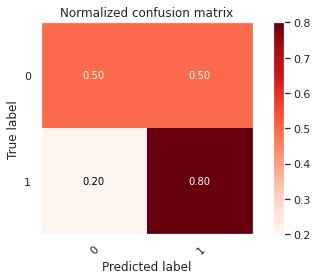

In [72]:
# This is Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, oob_score=True, criterion='entropy',
                            max_features='log2', random_state=123)
cvs = cross_val_score(clf, x, data["target"], scoring='accuracy', cv=3)
print(np.mean(cvs), np.std(cvs))

clf.fit(x_tr, y_tr)
#print(np.array(y_ts))
plt.figure( dpi=100)
plot_confusion_matrix(np.array(y_ts), clf.predict(x_ts), [0,1], normalize=True)
plt.grid(False)
plt.savefig("drive/Опрос/pics/cm_rf_test_only_with_pol.png")


## Classifyer with questions

In [0]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# this operation performorms normalization to the data. In this case, from features we subtract mean
# and then features will be divided by varience. This step is nessesary for many ML techniques. There is, for example, MinMax scaller.
std_sc = StandardScaler()
x = std_sc.fit_transform(data.drop(columns=["target"]))
                         
# Here we divide our dataset on test and train datasets.
x_tr, x_ts, y_tr, y_ts = train_test_split(x, data["target"], test_size=0.30)

0.5476190476190476 0.038880789567986955
Normalized confusion matrix
[[0.5  0.5 ]
 [0.35 0.65]]


<Figure size 600x400 with 0 Axes>

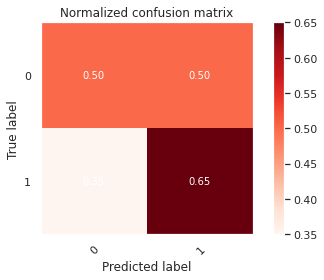

In [74]:
# This is Logistic Regression classifier
clf = LogisticRegression(penalty="l2", random_state=123)
cvs = cross_val_score(clf, x, data["target"], scoring='accuracy', cv=3,)
print(np.mean(cvs), np.std(cvs))
clf.fit(x_tr, y_tr)
plt.figure( dpi=100)
plot_confusion_matrix(np.array(y_ts), clf.predict(x_ts), [0,1], normalize=True)
plt.grid(False)
plt.savefig("drive/Опрос/pics/cm_lr_with_questions.png")

0.5952380952380953 0.038880789567986955
Normalized confusion matrix
[[0.27777778 0.72222222]
 [0.1        0.9       ]]


<Figure size 600x400 with 0 Axes>

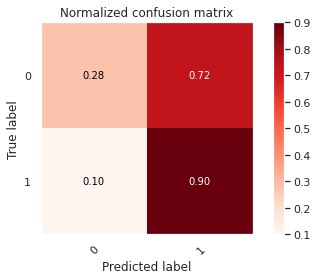

In [75]:
# This is Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, oob_score=True, criterion='entropy',random_state=123)
cvs = cross_val_score(clf, x, data["target"], scoring='accuracy', cv=3)
print(np.mean(cvs), np.std(cvs))

clf.fit(x_tr, y_tr)
plt.figure( dpi=100)
plot_confusion_matrix(np.array(y_ts), clf.predict(x_ts), [0,1], normalize=True)
plt.grid(False)
plt.savefig("drive/Опрос/pics/cm_rf_with_questions.png")

## Classifyer with questions with polinominal features


In [0]:
data_pol = get_polinomial_features(data, 2, 'target',)
data_pol['target'] = data['target'].reset_index(drop=True)

In [0]:
correlations = correletion(data_pol, 'target')
correlations = correlations.drop('1')

In [0]:
list_filterd_columns = correlations[(abs(correlations) > 0.3)].keys()#
list_filterd_columns = list_filterd_columns.drop('target')

In [0]:
# if you want, you can uncomment next line to get a huge geatmap

#plt.subplots(figsize=(20,15))
#sns.set(font_scale=2)
#sns.heatmap(data[list_filterd_columns].corr())

In [0]:
# this operation performorms normalization to the data. In this case, from features we subtract mean
# and then features will be divided by varience. This step is nessesary for many ML techniques. There is, for example, MinMax scaller.

from sklearn.preprocessing import MinMaxScaler, StandardScaler

std_sc = StandardScaler()
x = std_sc.fit_transform(data_pol.drop(columns=["target"])[list_filterd_columns]) #


#mm_sc = MinMaxScaler()
#x = mm_sc.fit_transform(data.drop(columns=["target"])[list_filterd_columns])

# Here we divide our dataset on test and train datasets.
x_tr, x_ts, y_tr, y_ts = train_test_split(x, data_pol["target"], test_size=0.30, shuffle=True)

0.6984126984126983 0.011223917161691244
Normalized confusion matrix
[[0.36842105 0.63157895]
 [0.15789474 0.84210526]]


<Figure size 600x400 with 0 Axes>

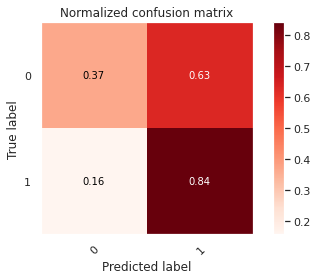

In [81]:
# This is Logistic Regression classifier
clf = LogisticRegression(penalty="l2", random_state=123)
cvs = cross_val_score(clf, x, data_pol["target"], scoring='accuracy', cv=3)
print(np.mean(cvs), np.std(cvs))
plt.figure( dpi=100)
clf.fit(x_tr, y_tr)
plot_confusion_matrix(np.array(y_ts), clf.predict(x_ts), [0,1], normalize=True)
plt.grid(False)
plt.savefig("drive/Опрос/pics/cm_lr_with_questions_with_pol.png")

0.6984126984126985 0.04046840883803797
Normalized confusion matrix
[[0.42105263 0.57894737]
 [0.10526316 0.89473684]]


<Figure size 600x400 with 0 Axes>

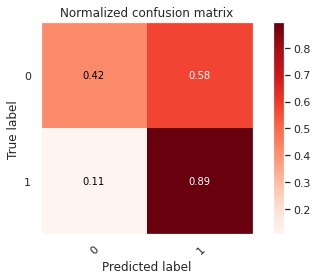

In [83]:
# This is Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, oob_score=True, criterion='entropy', random_state=123)
cvs = cross_val_score(clf, x, data_pol["target"], scoring='accuracy', cv=3)
print(np.mean(cvs), np.std(cvs))

clf.fit(x_tr, y_tr)
#print(np.array(y_ts))
plt.figure( dpi=100)
plot_confusion_matrix(np.array(y_ts), clf.predict(x_ts), [0,1], normalize=True)
plt.grid(False)
plt.savefig("drive/Опрос/pics/cm_rf_with_questions_with_pol.png")

# Comparing the classifier and test


In [84]:
# (Some ugly steps) Again take a data like priviously, but with hard encoded profession result 
# Shuffle
df_tests_prof = df_tests_prof.sample(frac=1).reset_index(drop=True)
# These three complex expressions performs filtering data by man-technologies and man-sign_systems categories with 
# condition, that profession is liked by responder.
x_tests = df_tests_prof[((df_tests_prof["target"] == 2) | (df_tests_prof["target"] == 3)) & df_tests_prof["Вам нравится ваша профессия? Не по зарплате, не по удобствам и т. д., а именно сама деятельность."] == 1].iloc[:,-19:-4]
x_quests = df_tests_prof[((df_tests_prof["target"] == 2) | (df_tests_prof["target"] == 3)) & df_tests_prof["Вам нравится ваша профессия? Не по зарплате, не по удобствам и т. д., а именно сама деятельность."] == 1].iloc[:,7:-23]
target = df_tests_prof[((df_tests_prof["target"] == 2) | (df_tests_prof["target"] == 3)) & df_tests_prof["Вам нравится ваша профессия? Не по зарплате, не по удобствам и т. д., а именно сама деятельность."] == 1]["target"]
prof = df_tests_prof[((df_tests_prof["target"] == 2) | (df_tests_prof["target"] == 3)) & df_tests_prof["Вам нравится ваша профессия? Не по зарплате, не по удобствам и т. д., а именно сама деятельность."] == 1]["hard_res_only"]
# bring some order in the dataset
target.replace({2: 0, 3: 1}, inplace=True)
# now data contains only tests results, target, questions and hard results of profession test
data_with_prof = pd.concat([x_tests,x_quests, target,prof], axis="columns")

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [0]:
#encoding russian questions to form Q#
russian = data_with_prof.columns[15:-2]
repl = ['Q' + str(x) for x in range(len(russian))]
repl = {x:y for x,y in zip(russian, repl)}
repl_revers = {y:x for x,y in repl.items()}
data_with_prof = data_with_prof.rename(index=str, columns=repl)

In [0]:
def accuracy(y_ts, predict):
    comp = y_ts == predict
    unique, counts = np.unique(comp, return_counts=True)
    d = dict(zip(unique, counts))
    return float(d[True]) / float(y_ts.shape[0])

In [0]:
data_with_prof.hard_res_only = data_with_prof.hard_res_only.replace({"sign":1, "tech":0, "art": 2, "Nat":3, "man":4, 'e':5})

In [0]:
# expand dataset with polinominal features
save = data_with_prof.hard_res_only
pol_data_prof = get_polinomial_features(data_with_prof.drop("hard_res_only", axis=1), 2, 'target')
pol_data_prof['hard_res_only'] = save.reset_index(drop=True)


In [0]:
# and know, due to huge new features, lets filter them by some correlation treshold
correlations = correletion(pol_data_prof.drop("hard_res_only", axis=1), 'target')
list_filterd_columns = correlations[(correlations > 0.3) | (correlations < -0.2)].keys()
list_filterd_columns = list_filterd_columns.drop(['target'])

In [0]:
l = list(list_filterd_columns)
l.append("hard_res_only") 

In [0]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#std_sc = StandardScaler()
save = pol_data_prof.hard_res_only
x = std_sc.fit_transform(pol_data_prof.drop(columns=["target"])[l]) #
x = pol_data_prof.drop(columns=["target"])[l]
x['hard_res_only'] = save.reset_index(drop=True)

#mm_sc = MinMaxScaler()
#x = mm_sc.fit_transform(data.drop(columns=["target"])[list_filterd_columns])

# Here we divide our dataset on test and train datasets.
x_tr, x_ts, y_tr, y_ts = train_test_split(x.to_numpy(), pol_data_prof["target"], test_size=0.30, shuffle=True)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


0.6825396825396824 0.07360014678964842


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


0.6825396825396824 0.07360014678964842
0.6825396825396824 0.07360014678964842
0.6825396825396824 0.07360014678964842


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


0.6825396825396824 0.07360014678964842
0.6825396825396824 0.07360014678964842
0.6825396825396824 0.07360014678964842


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


0.6825396825396824 0.07360014678964842
0.6825396825396824 0.07360014678964842
0.6825396825396824 0.07360014678964842
Normalized confusion matrix
[[0.625      0.375     ]
 [0.27272727 0.72727273]]


<Figure size 600x400 with 0 Axes>

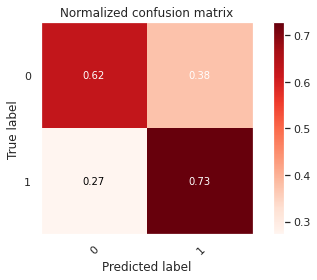

In [94]:
acc_test = []
acc_clf = []
for _ in range(10):
    x_tr, x_ts, y_tr, y_ts = train_test_split(x.to_numpy(), pol_data_prof["target"], test_size=0.30, shuffle=True)
    # This is Random Forest classifier
    clf = LogisticRegression(penalty="l2", random_state=123)#RandomForestClassifier(n_estimators=100, oob_score=True, criterion='entropy', random_state=123)
    cvs = cross_val_score(clf, x, pol_data_prof["target"], scoring='accuracy', cv=3)
    print(np.mean(cvs), np.std(cvs))
    clf.fit(x_tr[:,:-1], y_tr)
    acc_test.append(accuracy(y_ts, x_ts[:,-1]))
    acc_clf.append(accuracy(y_ts, clf.predict(x_ts[:,:-1])))

#print(np.array(y_ts))
plt.figure( dpi=100)
plot_confusion_matrix(np.array(y_ts), clf.predict(x_ts[:,:-1]), [0,1], normalize=True)
plt.grid(False)
plt.savefig("drive/Опрос/pics/cm_lr_with_questions_with_pol_final.png")

In [95]:
print("Accuracy of the profficiency test: {:.2} +/- {:.2}".format(np.mean(acc_test), np.std(acc_test)))
print("Accuracy of the classifier: {:.2} +/- {:.2}".format(np.mean(acc_clf), np.std(acc_clf)))

Accuracy of the profficiency test: 0.25 +/- 0.021
Accuracy of the classifier: 0.71 +/- 0.055


# Analize of classifires


In [96]:
get_featrue_importance_lr(clf, l[:-1], x_ts[:,:-1])

,value,name
0,0.916530,Q11 Q92
1,0.739014,Openn Q11
2,0.611891,Neuro Q15
3,0.418799,Q11 Q32
4,0.124221,Neuro Q11
5,0.019474,Q11 Q26
6,0.006716,empathy Q7
7,0.001681,Q7 Q46
8,-0.152755,sign Q11
9,-0.156314,empathy Q52


In [97]:
# df.iloc[:,7:31] - EQ-test Q0 - Q23
# df.iloc[:, 31:81] - big five test Q25 - Q75
# df.iloc[:, 81:111] - prof test Q74 - Q103 
print("Q3: {}".format(repl_revers["Q3"]))
print("Q7: {}".format(repl_revers["Q7"]))
print("Q11: {}".format(repl_revers["Q11"]))
print("Q15: {}".format(repl_revers["Q15"]))
print("Q26: {}".format(repl_revers["Q26"]))
print("Q27: {}".format(repl_revers["Q27"]))
print("Q32: {}".format(repl_revers["Q32"]))
print("Q46: {}".format(repl_revers["Q46"]))
print("Q52: {}".format(repl_revers["Q52"]))
print("Q92: {}".format(repl_revers["Q92"]))


Q3: Я могу точно описать, что я чувствую [■]
Q7: Я чувствую себя несчастным [■]
Q11: Моя карьера движется в правильном направлении [■]
Q15: Мои коллеги необщительны [■]
Q26: Я всегда готов к неожиданным ситуациям [■]
Q27: Я не стрессоустойчивый [■]
Q32: Я почти всегда спокоен [■]
Q46: Я предпочитаю выполнять всю работу по дому сразу [■]
Q52: Я легко расстраиваюсь [■]
Q92: Я могу ясно излагать свои мысли в письменной форме
